# Classically-Boosted Variational Quantum Eigensolver

There is much interest in using quantum computers to estimate electronic ground state energies. Mainly, in the NISQ era this is done using VQE approaches. But VQE is limited by noise and by the need to perform many circuit repetitions. In particular the error gets worse when we increase the number of gates. In order to address this problem, people considered different generalizations/improvements of VQE. In this demo we will describe a classically-boosted version of the VQE (CB-VQE) algorithm which allows us to reduce the number of measurements required for a certain fixed GS energy precision.

In the paper <span style="color:red">(add link)</span>., they compute the sensitivity to device and sampling error for the simplest version of CB-VQE, where they consider the generalized eigenvalue problem in a subspace expanded by only one classical (single Slater determinant, in this case Hartree-Fock) and one quantum state (obtained as the output of a normal VQE). We see that, as expected, the sensitivity to sampling error vanishes when the groundstate can be described in terms of the classical states, and in ageneral this technique will allow us to reduce the number of measurements [required to reach a certain error threshold]. 

This demo is structured as follows:
- First we explain how to perform normal VQE for the $Li_2$ molecule and we obtain the optimized energy.
- Then, we compute all the entries of the Hamiltonian and the S matrix that will be needed for the generalized eigenvalue problem, for the case in which the subspace is spanned only by one classical and one quantum state.
- We will solve the generalized eigenvalue problem and find the ground state energy.
- Finally, we will discuss the number of measurements needed for a fixed precision by computing the variances of several quantities. 
<span style="color:red">(We still need to figure out how to do this or what we wanna write)</span>.


## NORMAL VQE

Let us first review the idea behind normal VQE, which can be also found in this demo <span style="color:red">(add link)</span>. 
In particular, for this demo we choose the molecule Li2. 
We will take the basis 6-31G from pennylane and take M active orbitals and N electrons <span style="color:red">(re-check these numbers)</span>.

Then, we are interested in finding the lowest eigenvalue of the Schroedinger equation

$$
H \vert \phi \rangle = E  \vert \phi \rangle
$$

and therefore to minimize the energy we use the following cost function

$$
\langle \phi \vert H \vert \phi \rangle
$$

where $\vert \phi \rangle$ is the output of applying a given ansatz (in this case all singles and doubles) to $\vert 0^N \rangle$, with a given set of external parameters that we are classically optimizing. <span style="color:red">(improve explanation)</span>

15
Step = 0,  Energy = -14.86704134 Ha
Step = 2,  Energy = -14.86874520 Ha
Step = 4,  Energy = -14.87017151 Ha
Step = 6,  Energy = -14.87136246 Ha
Step = 8,  Energy = -14.87235486 Ha
Step = 10,  Energy = -14.87318045 Ha
Step = 12,  Energy = -14.87386636 Ha
Step = 14,  Energy = -14.87443562 Ha
Step = 16,  Energy = -14.87490768 Ha
Step = 18,  Energy = -14.87529890 Ha
Step = 20,  Energy = -14.87562295 Ha
Step = 22,  Energy = -14.87589128 Ha
Step = 24,  Energy = -14.87611340 Ha
Step = 26,  Energy = -14.87629724 Ha
Step = 28,  Energy = -14.87644938 Ha
Step = 30,  Energy = -14.87657527 Ha
Step = 32,  Energy = -14.87667945 Ha
Step = 34,  Energy = -14.87676565 Ha
Step = 36,  Energy = -14.87683698 Ha
Step = 38,  Energy = -14.87689601 Ha
Step = 40,  Energy = -14.87694487 Ha
Step = 42,  Energy = -14.87698530 Ha
Step = 44,  Energy = -14.87701877 Ha
Step = 46,  Energy = -14.87704647 Ha
Step = 48,  Energy = -14.87706941 Ha
Step = 50,  Energy = -14.87708840 Ha
Step = 52,  Energy = -14.87710413 Ha
Ste

Text(0, 0.5, 'energy (Ha)')

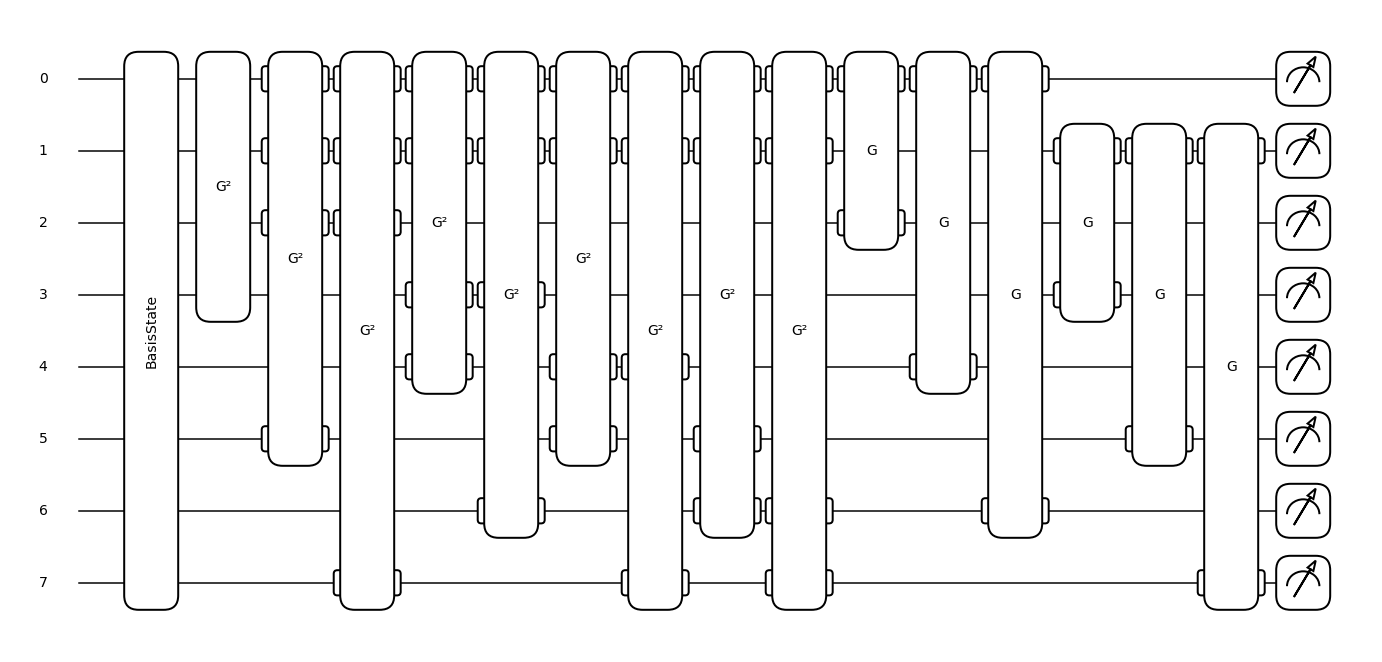

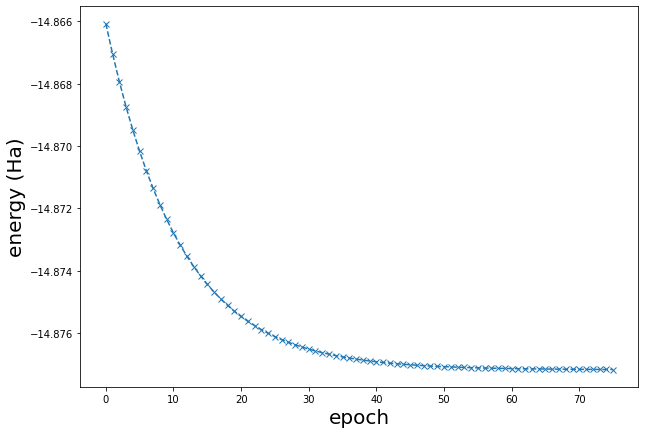

In [10]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

# Define the molecular Hamiltonian
symbols, coordinates = qml.qchem.read_structure('li2.xyz')

basis_set = "6-31G"
electrons = 2
orbitals = 4

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Define the HF initial state
hf = qml.qchem.hf_state(electrons, qubits)

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)
print(num_theta)
 
# Define a device
dev = qml.device('default.qubit', wires=qubits)

# Define the cost function and the circuit
def circuit(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

@qml.qnode(dev)
def cost_fn(theta):
    circuit(theta,range(qubits)) # Why define outside?
    return qml.expval(H)

# Draw circuit
qml.drawer.use_style('black_white')
qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

# Gradient descent optimization
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.zeros(num_theta, requires_grad=True)

#  Initial energy
energy = [cost_fn(theta)]
angle = [theta]

# Set the number of iterations and the convergence
max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):

    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(energy ,"x--")
plt.xlabel("epoch", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

## CLASSICALLY-BOOSTED VQE
We will now instead consider a generalized eigenvalue problem, [Connection to prev normal VQE]

$$
\bar{H} \vec{v}=  \lambda \bar{S} \vec{v}
$$

where we work in a subspace spanned by states $\{\vert \phi_\alpha \rangle\}$. 
The entries of $\bar{H}$ are obtained by projecting to the states in $\{\vert \phi_\alpha \rangle\}$ and $\bar{S}$ contains the overlaps.

Let us consider a simplified version of the problem, in which we just take one classical state, which is going to be a single Slater determinant, in this case the HF state, and a quantum state, which is going to be the result of a VQE (the optimized ansatz applied to the state $\vert 0^N \rangle$). Now, we need to compute all the entries of $\bar{H}$ and $\bar{S}$. 

In particular, we know that the GS energy of our problem will be the lowest eigenvalue of $\bar{H}$, $\lambda_0$, which, in our case, is two-dimensional, and that we will need to use the generalized eigenvalue equation to obtain $\lambda_0$ and $\lambda_1$.  

- The entry $H_{11}$ and $S_{\alpha, \alpha}$ can be computed classically so there is no noise/errors attached to them.
- The entry $H_{22}$ is exactly equivalent to the normal VQE that we considered before.
- Finally, the entries $H_{12}$, $H_{21}$ need to be calculated using Hadamard gates. In particular, we can decompose them into diffferent contributions, and we will need to compute the overlap between the quantum state and the computational basis states, as well as the overlap between the quantum state and the classical one for $S_{12}$. For the estimation of measurements, note that all these Hadamards also come with a variance (they are performed in the circuit).

Let us first define the molecular Hamiltonian again and the HF state:

In [11]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

# Define the molecular Hamiltonian
symbols = ["Li", "Li"]
coordinates = np.array([[-0.13150,0.0,0.0], [2.59150,0.0,0.0]])
basis_set = "6-31G"
electrons = 2
orbitals = 4

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Define the HF initial state
hf = qml.qchem.hf_state(electrons, qubits)

The entry H11 will just be the HF energy <span style="color:red">(can we do this more efficiently?)</span>

In [12]:
dev11 = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev11)
def circuit_H11():
    qml.BasisState(hf, wires=range(qubits))
    return qml.expval(H)

H11 = circuit_H11()

In [13]:
print(circuit_H11())

-14.746477967483099


The entry H22 will be the energy that we obtain from the normal VQE. Note that we are also interested in the ansatz which creates the state since we'll have to use it later: <span style="color:red">(just the same as before)</span>

15
Step = 0,  Energy = -14.74828820 Ha
Step = 2,  Energy = -14.75152668 Ha
Step = 4,  Energy = -14.75430354 Ha
Step = 6,  Energy = -14.75667446 Ha
Step = 8,  Energy = -14.75869180 Ha
Step = 10,  Energy = -14.76040355 Ha
Step = 12,  Energy = -14.76185289 Ha
Step = 14,  Energy = -14.76307803 Ha
Step = 16,  Energy = -14.76411240 Ha
Step = 18,  Energy = -14.76498495 Ha
Step = 20,  Energy = -14.76572061 Ha
Step = 22,  Energy = -14.76634067 Ha
Step = 24,  Energy = -14.76686323 Ha
Step = 26,  Energy = -14.76730366 Ha
Step = 28,  Energy = -14.76767494 Ha
Step = 30,  Energy = -14.76798803 Ha
Step = 32,  Energy = -14.76825214 Ha
Step = 34,  Energy = -14.76847505 Ha
Step = 36,  Energy = -14.76866327 Ha
Step = 38,  Energy = -14.76882230 Ha
Step = 40,  Energy = -14.76895673 Ha
Step = 42,  Energy = -14.76907043 Ha
Step = 44,  Energy = -14.76916667 Ha
Step = 46,  Energy = -14.76924817 Ha
Step = 48,  Energy = -14.76931723 Ha
Step = 50,  Energy = -14.76937579 Ha
Step = 52,  Energy = -14.76942547 Ha
Ste

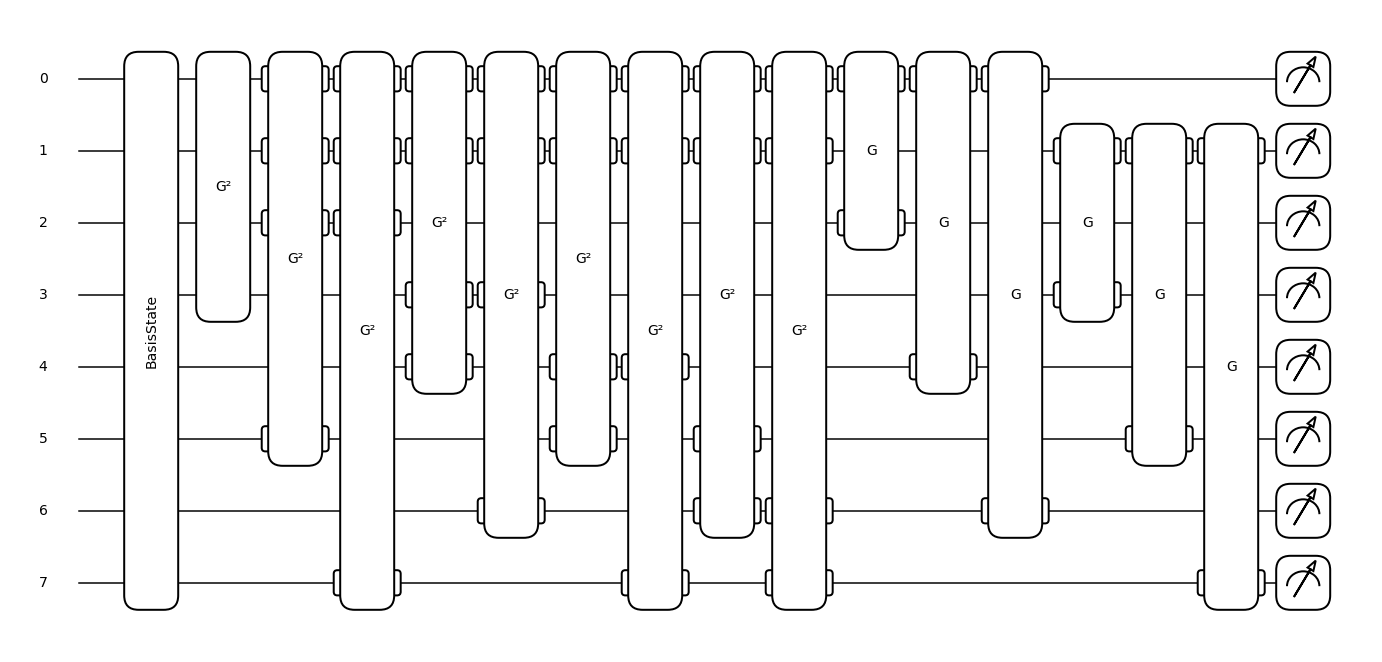

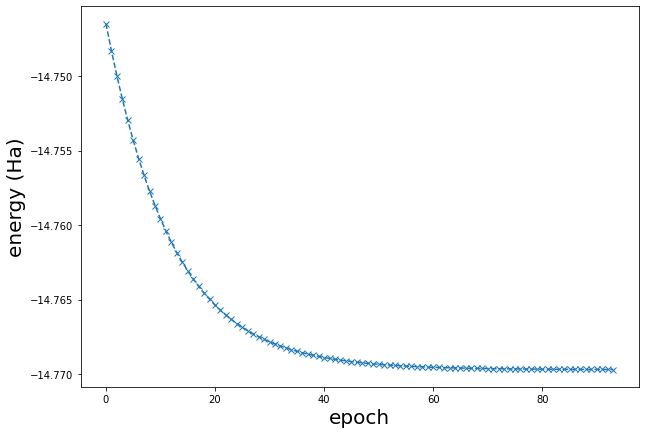

In [14]:
# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)
print(num_theta)
 
# Define a device
dev22 = qml.device('default.qubit', wires=qubits)

# Define the cost function and the circuit
def circuit(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

@qml.qnode(dev22)
def cost_fn(theta):
    circuit(theta,range(qubits))
    return qml.expval(H)

# Draw circuit
qml.drawer.use_style('black_white')
qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

# Gradient descent optimization
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.zeros(num_theta, requires_grad=True)

#  Initial energy
energy = [cost_fn(theta)]
angle = [theta]

# Set the number of iterations and the convergence
max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):

    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break
        
print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(energy ,"x--")
plt.xlabel("epoch", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

theta_opt = theta
H22 = cost_fn(theta)

Now let's compute the crossed terms! 
<span style="color:red">(Okay, so here I found a way to obtain the ansatz as a unitary, which is qml.matrix of a circuit. I don't know whether there is a better way. I am doing the same for the unitary which creates the HF state, and actually saying that this part is equal to W because it's common for both the quantum and the classical state preparation. The notation can be changed again!)</span>.

In [15]:
wires = range(qubits + 1)
dev_a = qml.device("default.qubit", wires=wires)

def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

def circuit_HF():
    for wire in range(electrons):
        qml.PauliX(wires=wire)
    for wire in range(electrons, qubits):
        qml.Identity(wires=wire)    
    
Vcl = np.identity(2**qubits)
Vq = qml.matrix(circuit_VQE)(theta_opt, range(qubits))
W = qml.matrix(circuit_HF)()

@qml.qnode(dev_a)
def hadamard_test(Vq, Vcl, W, component='real'):
    
    if component == 'imag':
        qml.RX(math.pi/2, wires=a_wires)
    
    qml.Hadamard(wires=[0])
    qml.QubitUnitary(W, wires=wires[1:])
    qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
    qml.Hadamard(wires=[0])
    
    return qml.probs(wires=[0])

probs = hadamard_test(Vq, Vcl, W)
y = 2*probs-1

<span style="color:red">(Now I compute the Hamiltonian and S crossed entries (eq. 11 and 12 of the paper). But I am not entirely sure I am doing eq. 11 correctly, actually here I think I am missing something. What are the computational basis states?? It seems to me that i0 is the HF state, and also we only have two y_i, but then what is i1?? It cannot be the quantum state or we are back to the same. Let me know if you undersand this part... )</span>.

In [16]:
H12 = y[0]*H11 + y[1]
H21 = np.conjugate(H12)

S = np.array([[1, y[0]],[y[0], 1]])
H = np.array([[H11, H12],[H21, H22]])

Finally, we solve the generalized eigenvalue problem.

In [17]:
from scipy import linalg
evals = linalg.eigvals(H, S)
print('GS energy: ', evals[1])

GS energy:  (-14.76969756216756+0j)


# DISCUSSION ON THE NUMBER OF MEASUREMENTS GIVEN A FIXED OVERLAP AND PRECISION

Now, the goal of the paper is actually estimating the number of measurements needed to obtain a fixed variance in the energies for both VQE and CB VQE.

For doing this, we need to expand the variance of the eigenvalues and obtain an expression in terms of the overlaps. Then, if we fix a precision of $1 mHa$, what is the number of measurements needed?

The ration between them will be the speed up that we obtain.

linalg.eigvals(H, S)

<span style="color:red">(This part is totally missing. Mmhhh I was thinking we could compute something using the measurement implemented in pennylane qml.var(), which directly gives you the variances. I will try to check next week!)</span>.